Imports

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPool1D, Conv2D, MaxPool2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import SimpleRNN
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Download the Dataset

In [3]:
import os
os.chdir('/content/drive/MyDrive/RML2016_dataset/') 
Data = pickle.load(open("RML2016.10b.dat",'rb'), encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Data.keys())))), [1,0])

In [4]:
print(f"Mods: {mods}")
print(f"SNRs: {snrs}")

Mods: [b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
SNRs: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [5]:
X = []     
label = []
snr_mod_labels = []
for snr in snrs:
  x = []
  y = []
  curr_snr_labels = []
  for mod in mods:
    x.append(Data[(mod,snr)])
    y.append([mod] * Data[(mod,snr)].shape[0])
    curr_snr_labels.append([snr, mod] * Data[(mod,snr)].shape[0])
  y = np.array(y)
  curr_snr_labels = np.array(curr_snr_labels)
  label.append(y.reshape((y.shape[0] * y.shape[1])))
  snr_mod_labels.append(curr_snr_labels.reshape((int(curr_snr_labels.shape[1]/2) * curr_snr_labels.shape[0], 2)))
  X.append(np.vstack(x))
label = np.array(label)
X = np.array(X)
snr_mod_labels = np.array(snr_mod_labels)

In [6]:
print(X.shape)
print(label.shape)
print(snr_mod_labels.shape)

(20, 60000, 2, 128)
(20, 60000)
(20, 60000, 2)


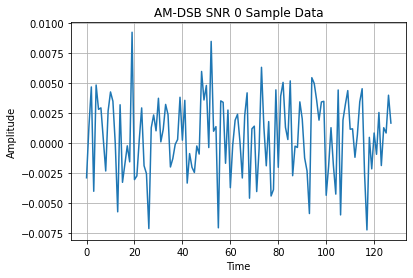

In [7]:
plt.plot(Data[b'AM-DSB',0][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("AM-DSB SNR 0 Sample Data")
plt.grid(b=True, axis='both')

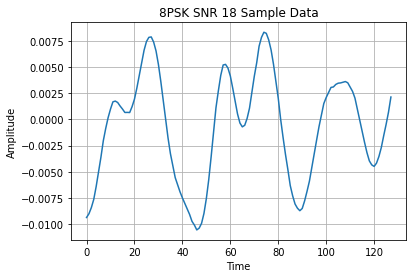

In [8]:
plt.plot(Data[b'8PSK',18][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("8PSK SNR 18 Sample Data")
plt.grid(b=True, axis='both')

## Data Splitting And Balancing

In [9]:
#Reshaping dataset
samples = X.reshape((X.shape[0] * X.shape[1], X.shape[2], X.shape[3], 1))
labels = snr_mod_labels.reshape((-1, 2)) # Notic that the labels are at this format [snr, modulation]

In [10]:
print('samples shape:', samples.shape)
print('labels shape:', labels.shape)

samples shape: (1200000, 2, 128, 1)
labels shape: (1200000, 2)


In [11]:
#Splitting data
training_val_data, testing_data, training_val_pair_labels, testing_pair_labels = train_test_split(samples, labels,stratify=labels, shuffle=True, test_size=0.3)
training_data, validation_data, training_pair_labels, validation_pair_labels =  train_test_split(training_val_data, training_val_pair_labels,stratify=training_val_pair_labels, shuffle=True, test_size=0.05)

In [12]:
training_labels = training_pair_labels[:, 1]
validation_labels = validation_pair_labels[:, 1]

In [13]:
print('training data shape:', training_data.shape)
print('training labels shape:', training_labels.shape)
print('validation data shape:', validation_data.shape)
print('validation labels shape:', validation_labels.shape)
print('testing data shape:', testing_data.shape)
print('testing labels shape:', testing_pair_labels.shape)

training data shape: (798000, 2, 128, 1)
training labels shape: (798000,)
validation data shape: (42000, 2, 128, 1)
validation labels shape: (42000,)
testing data shape: (360000, 2, 128, 1)
testing labels shape: (360000, 2)


In [14]:
unique, counts = np.unique(training_labels, return_counts=True)
print('training:\t', dict(zip(unique, counts)))
unique, counts = np.unique(validation_labels, return_counts=True)
print('validation:\t', dict(zip(unique, counts)))
unique, counts = np.unique(testing_pair_labels, return_counts=True)
print('testing:\t', dict(zip(unique, counts)))

training:	 {b'8PSK': 79800, b'AM-DSB': 79800, b'BPSK': 79800, b'CPFSK': 79800, b'GFSK': 79800, b'PAM4': 79800, b'QAM16': 79800, b'QAM64': 79800, b'QPSK': 79800, b'WBFM': 79800}
validation:	 {b'8PSK': 4200, b'AM-DSB': 4200, b'BPSK': 4200, b'CPFSK': 4200, b'GFSK': 4200, b'PAM4': 4200, b'QAM16': 4200, b'QAM64': 4200, b'QPSK': 4200, b'WBFM': 4200}
testing:	 {b'-10': 18000, b'-12': 18000, b'-14': 18000, b'-16': 18000, b'-18': 18000, b'-2': 18000, b'-20': 18000, b'-4': 18000, b'-6': 18000, b'-8': 18000, b'0': 18000, b'10': 18000, b'12': 18000, b'14': 18000, b'16': 18000, b'18': 18000, b'2': 18000, b'4': 18000, b'6': 18000, b'8': 18000, b'8PSK': 36000, b'AM-DSB': 36000, b'BPSK': 36000, b'CPFSK': 36000, b'GFSK': 36000, b'PAM4': 36000, b'QAM16': 36000, b'QAM64': 36000, b'QPSK': 36000, b'WBFM': 36000}


In [15]:
# converting labels to one hot encoding
training_onehot = OneHotEncoder(sparse = False).fit_transform(training_labels.reshape(-1,1))
validation_onehot = OneHotEncoder(sparse = False).fit_transform(validation_labels.reshape(-1,1))

In [16]:
print('training onehot encoding shape:', training_onehot.shape)
print('validation onehot encoding shape:', validation_onehot.shape)

training onehot encoding shape: (798000, 10)
validation onehot encoding shape: (42000, 10)


## Scoring functions

In [17]:
def model_pred_and_accuracy(model, testing_data, testing_labels):
  pred = model.predict(testing_data)
  pred = np.argmax(pred, axis=1)
  testing_labels = np.argmax(testing_labels, axis=1)

  return pred, accuracy_score(testing_labels, pred)

In [18]:
def confusion_matrixf(pred, actual, title):
  actual_decode = np.argmax(actual, axis=1)
  pred_decode = np.argmax(actual, axis=1)
  confusion_mtx = confusion_matrix(actual_decode, pred_decode)
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx, xticklabels=mods, yticklabels=mods, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.title(title)
  plt.show()

In [19]:
def model_scoring(model, testing_data, testing_pair_labels):
  sorted_idx = testing_pair_labels[:, 0].astype(int).argsort() # sort by snr value
  testing_data = testing_data[sorted_idx] # to sort samples by snr
  testing_pair_labels = testing_pair_labels[sorted_idx] # to sort labels by snr

  SNRs = testing_pair_labels[:, 0]
  modulations = testing_pair_labels[:, 1]
  unique_snr, snr_count = np.unique(SNRs, return_counts=True)
  snr_count_dict = dict(zip(unique, counts))


  curr_sample = 0
  for snr in range(len(unique_snr)):
    curr_snr = SNRs[curr_sample]
    curr_snr_samples = []
    curr_snr_labels = []
    for j in range(snr_count_dict[curr_snr]):
      curr_snr_samples.append(testing_data[curr_sample])
      curr_snr_labels.append(modulations[curr_sample])
      curr_sample += 1
    
    curr_snr_samples = np.array(curr_snr_samples)
    curr_snr_labels = np.array(curr_snr_labels)
    onehot_labels = OneHotEncoder(sparse = False).fit_transform(curr_snr_labels.reshape(-1,1))

    pred, accuracy = model_pred_and_accuracy(model, curr_snr_samples, onehot_labels)
    confusion_matrixf(pred, curr_snr_labels, 'SNR: ' + str(curr_snr))

## CNN Model

In [20]:
learning_rate = 0.001
batch_size = 512
epochs = 50

In [21]:
cnn_model = Sequential()
cnn_model.add(Conv2D(256, 3, activation='relu', padding='same'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Conv2D(64, 3, strides=2, activation='relu', padding='same'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu' ))
cnn_model.add(Dense(10,  activation='softmax'))
cnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True,)
checkpointer = ModelCheckpoint(filepath='saved_models/classification.hdf5', verbose=1, save_best_only=True)

with tf.device('/device:GPU:0'):
  history = cnn_model.fit(training_data, training_onehot, batch_size=batch_size, epochs=epochs, validation_data=(validation_data, validation_onehot), callbacks=[es, checkpointer], verbose=1)

In [ ]:
model_scoring(cnn_model, testing_data, testing_pair_labels)